## **Checking GPU**

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from psutil import virtual_memory

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sat Oct  1 16:49:24 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    26W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 54.8 gigabytes of available RAM

You are using a high-RAM runtime!


# **Libraries used**

In [ ]:
!pip install unidecode

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#for emoji manipulations with our article texts 
!pip install emoji 
#for contractions substitutions in our article texts 
!pip install contractions

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive

import re
from re import sub
from time import time 
import logging
import multiprocessing

import pandas as pd
import numpy as np

from wordcloud import WordCloud

from unidecode import unidecode
import gensim
from gensim.models import KeyedVectors
from gensim.test.utils import get_tmpfile
from gensim.models.phrases import Phrases, Phraser
from gensim.models import Word2Vec
from collections import defaultdict
from IPython.display import display
from sklearn.cluster import KMeans
from imblearn.over_sampling import RandomOverSampler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score


import contractions
import emoji
import re


import nltk
from nltk.corpus import stopwords
from string import punctuation
import torch

In [ ]:
!pip install update gensim

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
nltk.download('stopwords')
nltk.download('punkt')

stop_words = stopwords.words('russian')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# **CODE**

In [ ]:
class Article_Dataset_prep():

  def __init__ (self, dataset):

    '''
    arguments: 
          "text" (DataFrame): DataFrame file name which will be preprocessed  
    '''
    self.dataset = dataset

  def normalisation (self, text, unidecode):

      ''' Pre process and convert texts to a list of words method '''

      #preprocessing the text column of the DF
      text = unidecode(text)
      text = str(text)
      text = text.lower()


      #Clean the text
      replace_content = ''
      text = emoji.demojize(text)# transform from emoji to a string
      # for k, v in contractions.contractions_dict.items():
      #   text = text.replace(k,v)#working word contractions
      text = re.sub(r'(.)\1+', r'\1\1', text)#removing letter repetition
      text = re.sub(r'[\?\.\!]+(?=[\?\.\!])',replace_content, text)#removing punctuation repetition
      text = re.sub('#+', ' ', text)# remove hashtag
      text = sub(r"[^A-Za-z0-9^,!?.\/'+]", " ", text)
      text = sub(r"\+", " plus ", text)
      text = sub(r",", " ", text)
      text = sub(r"\.", " ", text)
      text = sub(r"!", " ! ", text)
      text = sub(r"\?", " ? ", text)
      text = sub(r"'", " ", text)
      text = sub(r"_", " ", text)
      text = sub(r"<<", " ", text)
      text = sub(r">>", " ", text)
      text = sub(r"-", " ", text)
      text = sub(r"--", " ", text)
      text = sub(r":", " : ", text)
      text = sub(r"\s{2,}", " ", text)

      #text = text.split()

      return text

  def run(self):
      '''
      preparation of DF for further manipulations
      '''
      
      #cleaning the DataFrame
      df = self.dataset.dropna().drop_duplicates().reset_index(drop=True)
      #df.sentiment.value_counts()/len(df)

      #removing neutral class from our DataFrame as we will be working with positive and negative classes only
      df = df[df.sentiment != 'neutral']
      #df.sentiment.value_counts()/len(df)

      #removing the unimportant for our analysis column "ID" 
      df.pop('id')

      #  #undersampling, dealing with imbalancy of the dataset 
      # from imblearn.under_sampling import RandomUnderSampler 
      # rus = RandomUnderSampler()
      # train_x, train_y = rus.fit_resample(np.array(df['text']).reshape(-1, 1), np.array(df['sentiment']).reshape(-1, 1));
      # df = pd.DataFrame(list(zip([x[0] for x in train_x], train_y)), columns = ['text', 'sentiment']);

      #  #overampling, dealing with imbalancy
      # ros = RandomUnderSampler()
      # train_x, train_y = ros.fit_resample(np.array(df['text']).reshape(-1, 1), np.array(df['sentiment']).reshape(-1, 1));
      # df = pd.DataFrame(list(zip([x[0] for x in train_x], train_y)), columns = ['text', 'sentiment']);

      

      #calling the normalisation function of the text column in the DF
      #replacing russian letters with use of unidecode package and pre-processing the text
      df.text = df.text.apply(lambda x: self.normalisation(x, unidecode))

      #removing stopwords
      from nltk.tokenize import word_tokenize
      df.text = df.text.apply(lambda x: word_tokenize(x))
      df.text = [word for word in df.text if not word in stopwords.words()]

      #Converting sting value of the output to numeric
      sentiment  = {'positive': 1,'negative':-1} 
      df.sentiment = [sentiment[item] for item in df.sentiment] 

      return df
      

In [ ]:
class Word2Vect_Class():
  
  def __init__ (self, df, epochs, alpha, min_alpha, min_count, window):
    self.df = df.copy()
    self.epochs = epochs
    self.alpha = alpha
    self.min_alpha = min_alpha
    self.min_count = min_count
    self.window = window

  def sentences_f(self):
    
    df = self.df [self.df.text.str.len()>1]
    sentences = [row for row in df.text]

    #creating phrases model and bigrams and sentences for the Word2Vwc model
    phrases = Phrases(sentences, min_count=1, progress_per=50000)
    bigram = Phraser(phrases) #creating bigrams of words in the sentence
    sentences = bigram[sentences] #constructing a sentence of bigrams

    return sentences, bigram

  def Word2Vec_model(self, sentences):

    #creating Word2Vev model
    w2v_model = Word2Vec(min_count=self.min_count, window=self.window, size=300, sample=6e-5, alpha=self.alpha, min_alpha=self.min_alpha, negative=20, workers=multiprocessing.cpu_count()-1)
    start = time()
    w2v_model.build_vocab(sentences, progress_per=50000)
    print('Time to train the model: {} mins'.format(round((time() - start) / 60, 2)))

    #training the model
    start = time()
    w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=self.epochs, report_delay=1) #manipulate with diff parameters
    print('Time to build vocabulary: {} mins'.format(round((time() - start) / 60, 2)))
    w2v_model.init_sims(replace=True)
    
    #saving the model
    w2v_model.save("/content/gdrive/My Drive/Colab Notebooks/Thesis/word2vec.model")

    return w2v_model


  def run (self):
    
    #calling sentences_f function to create sentences for the Word2Vec model
    sentences, bigram = self.sentences_f()
    w2v_model = self.Word2Vec_model(sentences)

    df = self.df
    df['original'] = df.text
    df.original = df.original.str.join(' ')
    df.text = df.text.apply(lambda x: ' '.join(bigram[x]))
    df.sentiment = df.sentiment.astype('int8')
    df[['text', 'sentiment']].to_csv('dataset.csv', index=False)
    #saving the new DF
    df.to_csv('/content/gdrive/My Drive/Colab Notebooks/Thesis/prepared_dataset.csv', encoding='utf-8', index=False)

    return df, w2v_model

In [ ]:
## uploading saved for testing or debugging
# model = Word2Vec.load("/content/gdrive/My Drive/Colab Notebooks/Thesis/word2vec.model")

class KMeans_Model():

  def __init__ (self, df, model):

    self.df = df
    self.model_vectors = model.wv

  
  def dictionary_creation (self):
    
    #creating a KMeans model
    KM_model = KMeans(n_clusters=2, max_iter=8500, random_state=True, n_init=50).fit(X=self.model_vectors.vectors.astype('double'))

    # #to check which words belong to one cluster to decide whether it will be assigned as positive or neative
    self.model_vectors.similar_by_vector(KM_model.cluster_centers_[1], topn=10, restrict_vocab=None) #coisine similarity

    positive = 1 #positive cluster number
    positive_centroid = KM_model.cluster_centers_[positive] #positive centroid creation
    negative_centroid = KM_model.cluster_centers_[1-positive] #negative centroid creation

    new_dict = pd.DataFrame(self.model_vectors.vocab.keys())   
    new_dict.columns = ['words'] #creating a word column
    new_dict['vectors'] = new_dict.words.apply(lambda x: self.model_vectors[f'{x}']) #creating a column with vectors
    new_dict['cluster'] = new_dict.vectors.apply(lambda x: KM_model.predict([np.array(x)])) #creating a column of cluster
    new_dict.cluster = new_dict.cluster.apply(lambda x: x[0])

    new_dict['cluster_value'] = [1 if i==0 else -1 for i in new_dict.cluster] #creating a column of cluster value appropriate to what we have assigned as positive or negative 
    new_dict['closeness_score'] = new_dict.apply(lambda x: 1/(KM_model.transform([x.vectors]).min()), axis=1) #creating a column with closeness score
    new_dict['sentiment_coeff'] = new_dict.closeness_score * new_dict.cluster_value #creating a column of sentiment coefficient
    
    
    ##saving sentiment dictionary
    new_dict[['words', 'sentiment_coeff']].to_csv('/content/gdrive/My Drive/Colab Notebooks/Thesis/sentiment_dictionary.csv', index=False)
    #print(words)

    ##opening our dataset file
    # dataset = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/Thesis/prepared_dataset.csv')

    #map_dictionary = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/Thesis/sentiment_dictionary.csv')
    sentiment_dictionary = dict(zip(new_dict.words.values, new_dict.sentiment_coeff.values))
   

    return sentiment_dictionary

In [ ]:
class TFIDF_Model():
  
  def __init__ (self, df, sentiment_dictionary):

    self.df = df.copy()
    self.sentiment_dictionary = sentiment_dictionary

 
  def f_tfidf(self, x, transformed, features):

    coordinates = transformed[x.name].tocoo() #  vector coordinates
    coordinates.col = features.iloc[coordinates.col].values
    dict_coordinates = dict(zip(coordinates.col, coordinates.data)) # dict with each word of selected sent with its value - sentiment score

    return dict_coordinates


  def tfidf_score(self, x, transformed, features):

    new_dict = self.f_tfidf(x, transformed, features)
    return list(map(lambda y:new_dict[f'{y}'], x.text.split()))

  def replacement_f(self, word):
      '''
      Replacing words in sentences with their tfidf scores
      '''
      try:
          out = self.sentiment_dictionary[word]
      except KeyError:
          out = 0
      return out


  def run(self):

    text = self.df.text


    tfidf = TfidfVectorizer(tokenizer=lambda y: y.split(), norm=None)
    tfidf.fit(text)
    transformed = tfidf.transform(text) #transformed sentences
    features = pd.Series(tfidf.get_feature_names()) #names of all words

    tfidf_score = self.df.apply(lambda x: self.tfidf_score(x, transformed, features), axis = 1)

    # tfidf_score = self.df.apply(lambda x: self.tfidf_score(x, transformed, features), axis=1) 
    sentiment_coeff = text.apply(lambda x: list(map(lambda y: self.replacement_f(y), x.split())))#Replacing words in sentences with their tfidf scores

    #Merging both previous steps and getting the predictions:
    output = pd.DataFrame(data=[sentiment_coeff, tfidf_score, text, self.df.sentiment]).T
    output.columns = ['s_coeff', 'tfidf_scores', 'text', 'sentiment']
    output['sentiment_rate'] = output.apply(lambda x: np.array(x.loc['s_coeff']) @ np.array(x.loc['tfidf_scores']), axis=1)
    output['prediction'] = (output.sentiment_rate>0).astype('int8')
    output['sentiment'] = [1 if i==1 else 0 for i in output.sentiment]

    return output

  def predict(self, output):
       
    #Reporting model's metrics
    y_pred = output.prediction
    y_test = output.sentiment

    conf_matrix = pd.DataFrame(confusion_matrix(y_test, y_pred))
    display(conf_matrix)

    test_scores = accuracy_score(y_test,y_pred), precision_score(y_test, y_pred), recall_score(y_test, y_pred), f1_score(y_test, y_pred)
    scores = pd.DataFrame(data=[test_scores])
    scores.columns = ['Accuracy', 'Precision', 'Recall', 'F1-score']
    scores = scores.T
    scores.columns = ['scores']
    display(scores)
    
    return scores

# **Openning CSV files for further manipulations**

In [ ]:
  dataset = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/Thesis/prepared_dataset.csv')

In [ ]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
path = "/content/gdrive/My Drive/Colab Notebooks/Thesis/train.csv"
df = pd.read_csv(path)

# **run all in one function**

In [ ]:
def main(df, epochs, alpha, min_alpha, min_count, window):

  start = time()

  #preprocessing the DF
  new_d = Article_Dataset_prep(df)
  sample = new_d.run()
  #print(sample)

  #creating, running, saving the Word2Vec model + creating new df 
  new_model = Word2Vect_Class(sample, epochs, alpha, min_alpha, min_count, window)
  df, W2V_model = new_model.run()
  #print(df)
  
  #creating, running, saving the K-Means model with positive and negative clusters
  km_model = KMeans_Model(df, W2V_model)
  sentiment_dictionary = km_model.dictionary_creation()

  # uploading saved 
  dataset = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/Thesis/prepared_dataset.csv')

  tfidf_model = TFIDF_Model(dataset, sentiment_dictionary)
  output = tfidf_model.run()
  tfidf_model.predict(output)

  print('Total time spent to run {} epochs: {} mins'.format(epochs,(round((time() - start) / 60, 2))))

if __name__ == '__main__':
  number_epochs = 60
  #number_epochs = [1, 30, 50, 100, 150, 200] #for testing
  alpha = 0.01
  #alpha =[0.01,0.03, 0.3, 0.5, 0.7] #for testing
  min_alpha = 0.0007
  #min_alpha = [0.007, 0.003, 0.08, 0.1] #for testing
  # for i in range(len(min_alpha)):  #for testing
  min_count = 100
  window = 10
  results = main(df, number_epochs, alpha, min_alpha, min_count, window)
  print(results)


Time to train the model: 0.08 mins
Time to build vocabulary: 4.33 mins


/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  "The parameter 'token_pattern' will not be used"
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,0,1
0,251,1183
1,114,2681


,scores
Accuracy,0.693308
Precision,0.693841
Recall,0.959213
F1-score,0.805226


Total time spent to run 60 epochs: 5.65 mins
None


# **Visualisations of the Dataset**

In [ ]:
#opening our dataset file
dataset = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/Thesis/train.csv')

Dataset size: (8263, 3)
Total number of Google App Review: 8263


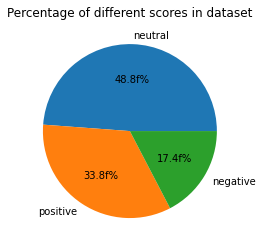

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


,text,id,sentiment
774,\nПо факту обрушения мостовой конструкции МВД ...,2828,neutral
4541,В рамках визита Президента Исламской Республик...,6595,positive
4165,Альберт Рау: для электромобилей уже предусмотр...,6219,neutral


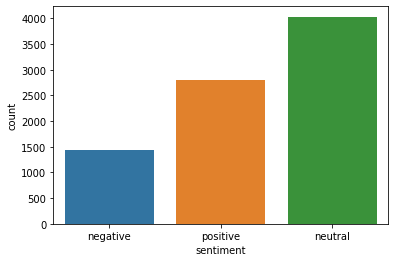

In [ ]:
print('Dataset size:',dataset.shape)
print('Total number of Google App Review: {}'.format(len(dataset)))

#visualisation of the % of score for each score type
score_representation = dataset['sentiment'].value_counts()
plt.pie(score_representation, labels = score_representation.index, autopct = '%1.1ff%%')
plt.title('Percentage of different scores in dataset')
plt.show()
sns.countplot(dataset.sentiment)
plt.xlabel('sentiment')
dataset.sample(3) #random rows in our dataset

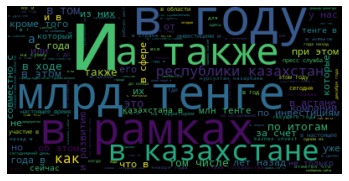

In [ ]:
# visualisation of most common words in articles with positive sentiment value
high_score = (dataset[dataset['sentiment']=='positive'])
text = ' '.join(score.lower() for score in high_score['text'])
wordcloud = WordCloud().generate(text)
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()

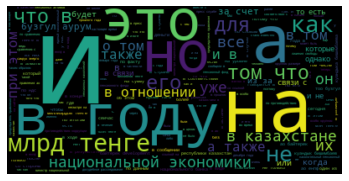

In [ ]:
# visualisation of most common words in articles with negative sentiment value
negative_score = dataset[dataset['sentiment']=='negative']
text = ' '.join(score.lower() for score in negative_score['text'])
wordcloud = WordCloud().generate(text)
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()